In [217]:
import os
import boto3
import re
import sagemaker

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io,sys,math,urllib.request
import time
import json
import sagemaker.amazon.common as smac
import seaborn as sns

In [220]:
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer 

In [218]:
role = sagemaker.get_execution_role()
print(role)
region = boto3.session.Session().region_name
# each region has its XGBoost container
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} 

bucket = sagemaker.Session().default_bucket()

prefix = 'sagemaker/CancerRiskPrediction'
print("Success - the MySageMakerInstance is in the " + region + " region. You will use the " + containers[region] + " container for your SageMaker endpoint.")

arn:aws:iam::359016722223:role/service-role/AmazonSageMaker-ExecutionRole-20200926T193458
Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [221]:
df=pd.read_csv("https://sagemaker-us-east-1-359016722223.s3.amazonaws.com/data.csv")
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [222]:
df.shape


(569, 33)

In [223]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [225]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [226]:
df.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [227]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

## Visualisation

Number of Benign:  357
Number of Malignant :  212


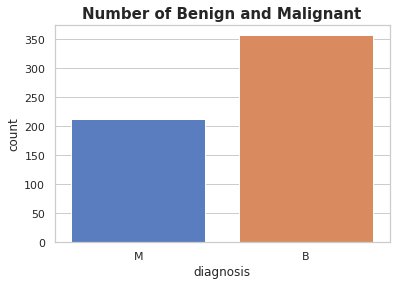

In [228]:
ax = sns.countplot(df.diagnosis,label="Count")       
B, M = df.diagnosis.value_counts()
plt.title("Number of Benign and Malignant",fontsize=15,fontweight="bold")
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

In [229]:
# y includes our labels and x includes our features
y = df.diagnosis                       
x = df.drop(df[['Unnamed: 32','id','diagnosis']],axis=1)
x.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [230]:
# first ten features
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())
data_n_2

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,...,1.885031,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,...,1.804340,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,...,1.510541,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,...,-0.281217,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,...,1.297434,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.109139,0.720838,2.058974,2.341795,1.040926,0.218868,1.945573,2.318924,-0.312314,-0.930209,...,1.899514,0.117596,1.751022,2.013529,0.378033,-0.273077,0.663928,1.627719,-1.358963,-0.708467
565,1.703356,2.083301,1.614511,1.722326,0.102368,-0.017817,0.692434,1.262558,-0.217473,-1.057681,...,1.535369,2.045599,1.420690,1.493644,-0.690623,-0.394473,0.236365,0.733182,-0.531387,-0.973122
566,0.701667,2.043775,0.672084,0.577445,-0.839745,-0.038646,0.046547,0.105684,-0.808406,-0.894800,...,0.560868,1.373645,0.578492,0.427529,-0.808876,0.350427,0.326479,0.413705,-1.103578,-0.318129
567,1.836725,2.334403,1.980781,1.733693,1.524426,3.269267,3.294046,2.656528,2.135315,1.042778,...,1.959515,2.235958,2.301575,1.651717,1.429169,3.901415,3.194794,2.287972,1.917396,2.217684


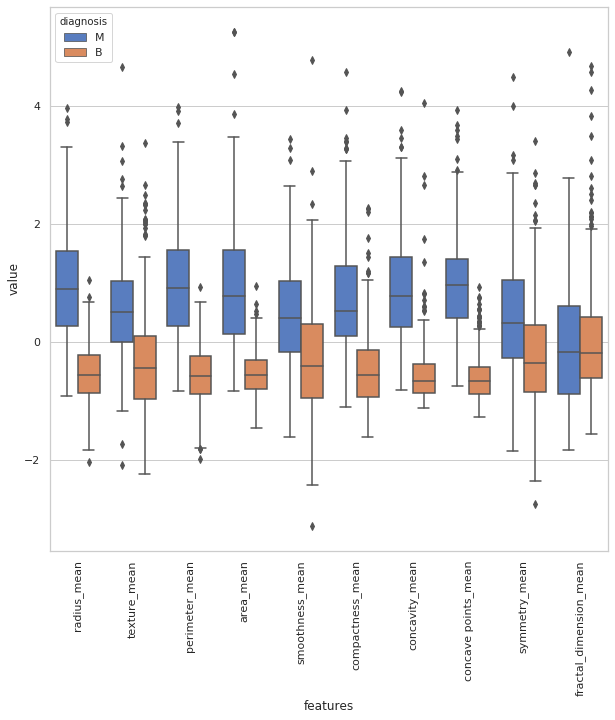

In [231]:
plt.figure(figsize=(10,10))
data = pd.concat([y,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis", var_name="features",value_name='value')
sns.boxplot(x="features", y="value", hue="diagnosis", data=data);
plt.xticks(rotation=90);

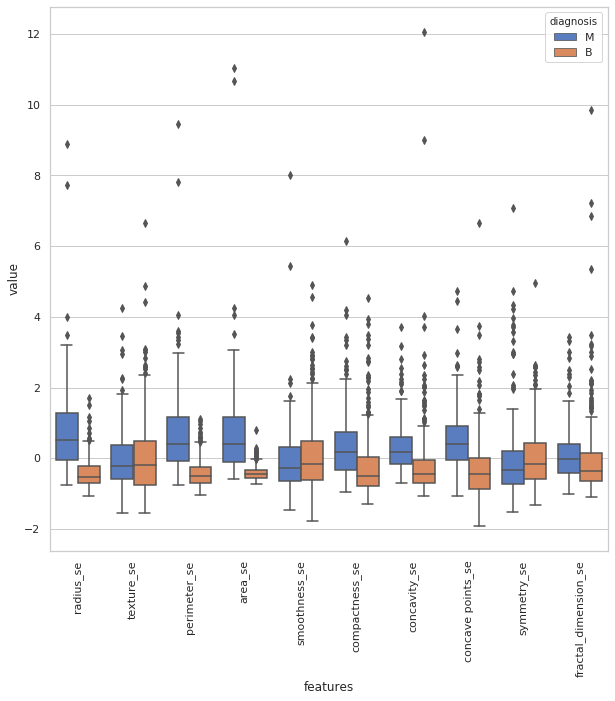

In [232]:
plt.figure(figsize=(10,10))
data = pd.concat([y,data_n_2.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis", var_name="features",value_name='value')
sns.boxplot(x="features", y="value", hue="diagnosis", data=data);
plt.xticks(rotation=90);

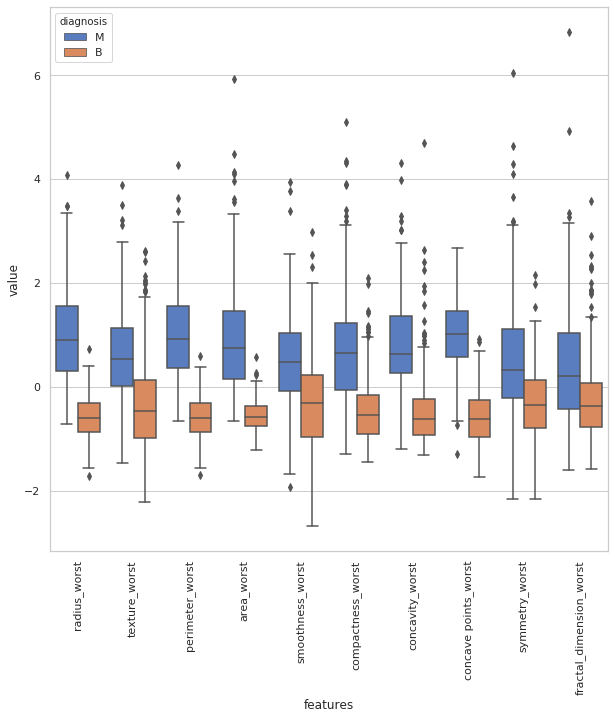

In [233]:
plt.figure(figsize=(10,10))
data = pd.concat([y,data_n_2.iloc[:,20:30]],axis=1)
data = pd.melt(data,id_vars="diagnosis", var_name="features",value_name='value')
sns.boxplot(x="features", y="value", hue="diagnosis", data=data);
plt.xticks(rotation=90);

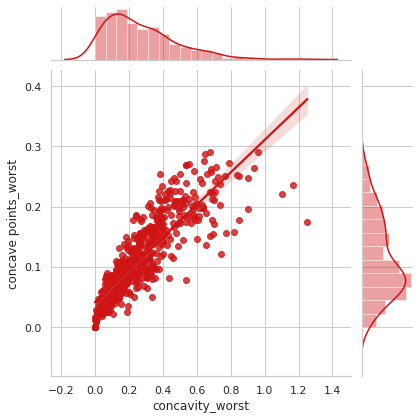

In [234]:
sns.jointplot(x.loc[:,'concavity_worst'], x.loc[:,'concave points_worst'], kind="regg", color="#ce1414");

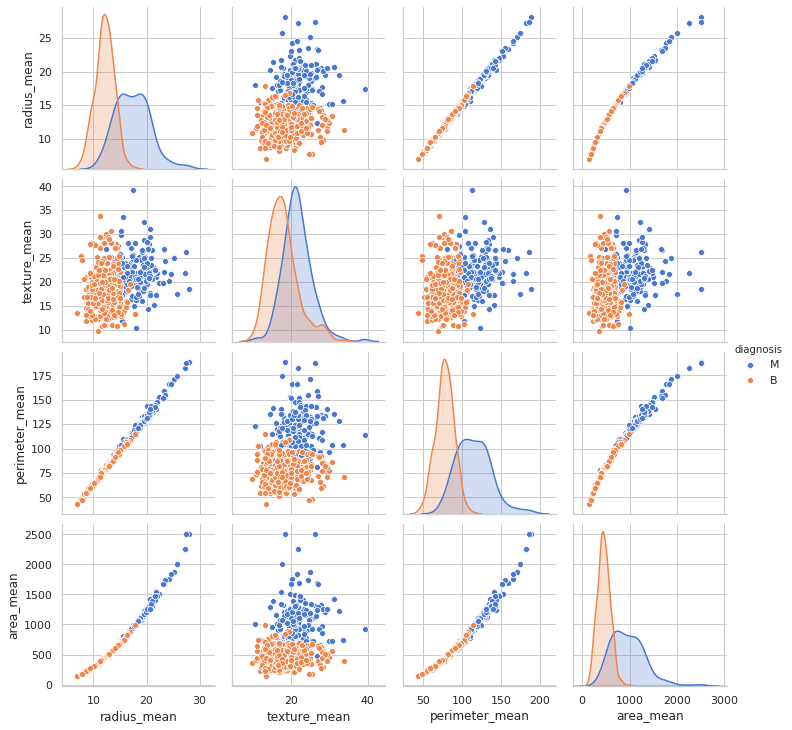

In [235]:
lables=df[['diagnosis', "radius_mean", "texture_mean", "perimeter_mean", "area_mean"]]
lables
sns.pairplot(lables,hue="diagnosis");
plt.show();

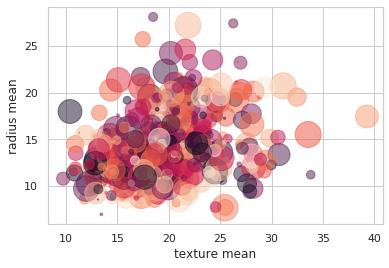

In [236]:
size = len(df['texture_mean'])

area = np.pi * (15 * np.random.rand( size ))**2
colors = np.random.rand( size )

plt.xlabel("texture mean")
plt.ylabel("radius mean") 
plt.scatter(df['texture_mean'], df['radius_mean'], s=area, c=colors, alpha=0.5);

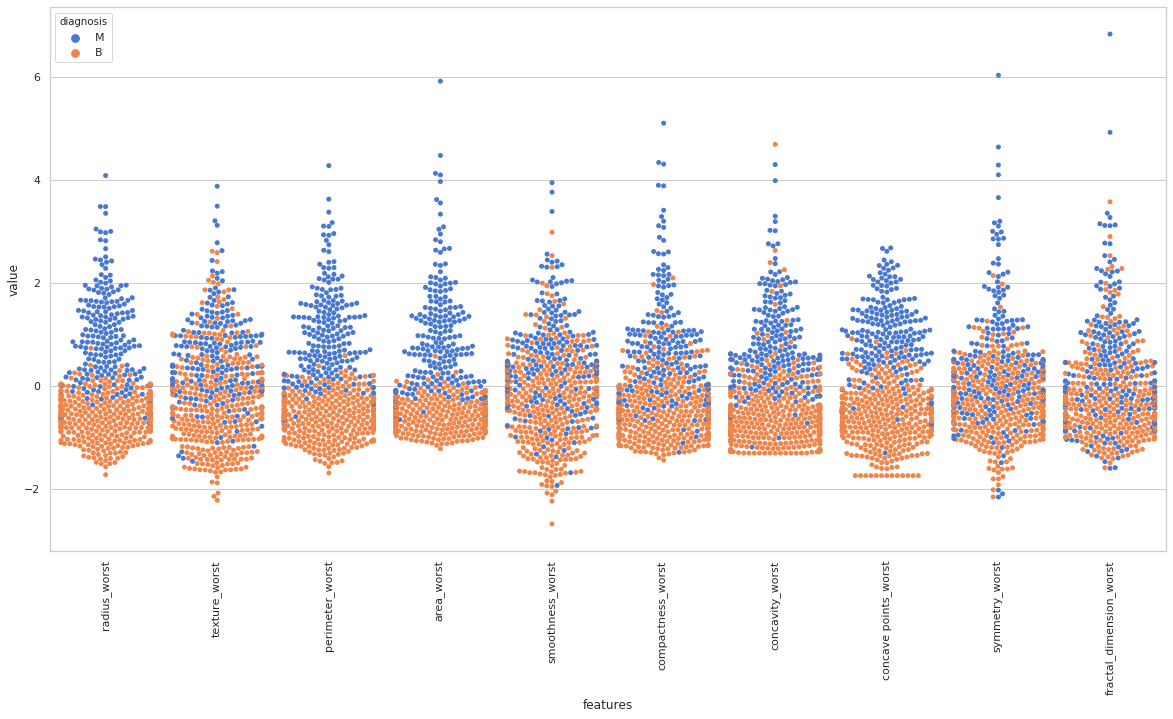

In [237]:
sns.set(style="whitegrid", palette="muted");
tic = time.time();
plt.figure(figsize=(20,10));
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data);
plt.xticks(rotation=90);

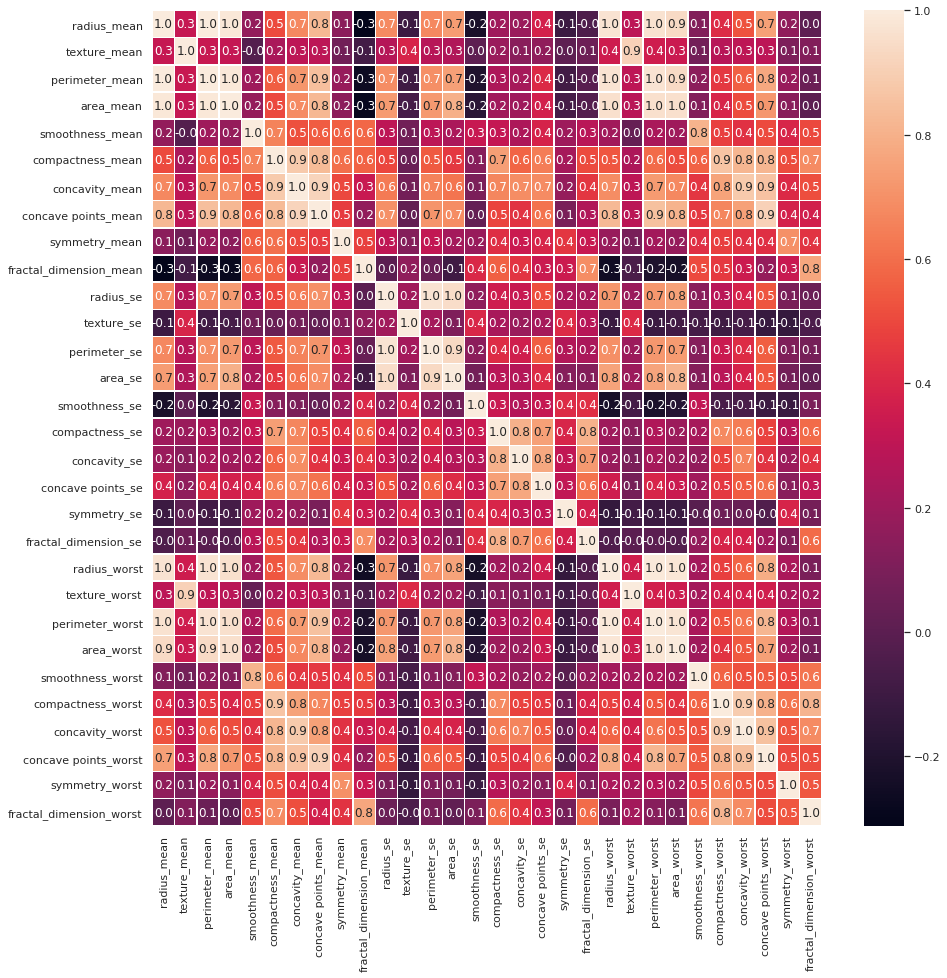

In [238]:
#correlation map
plt.subplots(figsize=(15,15));
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f');


In [239]:
df = df.drop(df[['Unnamed: 32','id']],axis = 1 )
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [240]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
df.diagnosis=lb.fit_transform(df.diagnosis)

In [241]:
X= df[["radius_mean","perimeter_mean","area_mean","radius_worst","perimeter_worst","area_worst","concave points_mean","concave points_worst"]]
Y=df['diagnosis']
print(X.shape)
print(Y.shape)
print(type(X))

(569, 8)
(569,)
<class 'pandas.core.frame.DataFrame'>


In [242]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
scaled_data=sc.fit_transform(X)

In [243]:
features=X.keys()
features

Index(['radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst',
       'perimeter_worst', 'area_worst', 'concave points_mean',
       'concave points_worst'],
      dtype='object')

In [244]:
dicti={}
for i in range(len(features)):
    dicti.update({features[i]:scaled_data[:,i]})

In [245]:
dataframe=pd.DataFrame(dicti)
dataframe

,radius_mean,perimeter_mean,area_mean,radius_worst,perimeter_worst,area_worst,concave points_mean,concave points_worst
0,0.521037,0.545989,0.363733,0.620776,0.668310,0.450698,0.731113,0.912027
1,0.643144,0.615783,0.501591,0.606901,0.539818,0.435214,0.348757,0.639175
2,0.601496,0.595743,0.449417,0.556386,0.508442,0.374508,0.635686,0.835052
3,0.210090,0.233501,0.102906,0.248310,0.241347,0.094008,0.522863,0.884880
4,0.629893,0.630986,0.489290,0.519744,0.506948,0.341575,0.518390,0.558419
...,...,...,...,...,...,...,...,...
564,0.690000,0.678668,0.566490,0.623266,0.576174,0.452664,0.690358,0.761512
565,0.622320,0.604036,0.474019,0.560655,0.520892,0.379915,0.486630,0.559450
566,0.455251,0.445788,0.303118,0.393099,0.379949,0.230731,0.263519,0.487285
567,0.644564,0.665538,0.475716,0.633582,0.668310,0.402035,0.755467,0.910653


In [246]:
dataframe=pd.concat([Y,dataframe],axis=1)
dataframe

,diagnosis,radius_mean,perimeter_mean,area_mean,radius_worst,perimeter_worst,area_worst,concave points_mean,concave points_worst
0,1,0.521037,0.545989,0.363733,0.620776,0.668310,0.450698,0.731113,0.912027
1,1,0.643144,0.615783,0.501591,0.606901,0.539818,0.435214,0.348757,0.639175
2,1,0.601496,0.595743,0.449417,0.556386,0.508442,0.374508,0.635686,0.835052
3,1,0.210090,0.233501,0.102906,0.248310,0.241347,0.094008,0.522863,0.884880
4,1,0.629893,0.630986,0.489290,0.519744,0.506948,0.341575,0.518390,0.558419
...,...,...,...,...,...,...,...,...,...
564,1,0.690000,0.678668,0.566490,0.623266,0.576174,0.452664,0.690358,0.761512
565,1,0.622320,0.604036,0.474019,0.560655,0.520892,0.379915,0.486630,0.559450
566,1,0.455251,0.445788,0.303118,0.393099,0.379949,0.230731,0.263519,0.487285
567,1,0.644564,0.665538,0.475716,0.633582,0.668310,0.402035,0.755467,0.910653


In [247]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(dataframe,test_size=0.2)

In [248]:
print(train_set.shape)
print(test_set.shape)

(455, 9)
(114, 9)


In [250]:
dataframe.to_csv('train.csv',index=False,header=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix,'train/train.csv')).upload_file('train.csv')
s3_input_train=sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix),content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [251]:
my_session=sagemaker.Session()
cancer_model=sagemaker.estimator.Estimator(containers[region],role,train_instance_count=1,train_instance_type='ml.m5.large',output_path='s3://{}/{}/output'.format(bucket,prefix),sagemaker_session=my_session)
cancer_model.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [252]:
cancer_model.fit({'train':s3_input_train})

2020-10-06 07:40:12 Starting - Starting the training job...
2020-10-06 07:40:14 Starting - Launching requested ML instances......
2020-10-06 07:41:33 Starting - Preparing the instances for training......
2020-10-06 07:42:35 Downloading - Downloading input data...
2020-10-06 07:43:10 Training - Downloading the training image..Arguments: train
[2020-10-06:07:43:25:INFO] Running standalone xgboost training.
[2020-10-06:07:43:25:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-10-06:07:43:25:INFO] File size need to be processed in the node: 0.09mb. Available memory size in the node: 249.46mb
[2020-10-06:07:43:25:INFO] Determined delimiter of CSV input is ','
[07:43:25] S3DistributionType set as FullyReplicated
[07:43:25] 569x8 matrix with 4552 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[07:43:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[0]#011train-error:0.056239
[07:43:25] src

In [253]:
predictor=cancer_model.deploy(initial_instance_count=1,instance_type='ml.m5.large')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [254]:
predictor.endpoint

'xgboost-2020-10-06-07-40-12-180'

In [255]:
from sagemaker.predictor import csv_serializer

In [257]:
#load the data into an array
test_data_array=test_set.drop('diagnosis',axis=1).values 

predictor.content_type = 'text/csv' # set the data type for an inference
predictor.serializer = csv_serializer # set the serializer type

print(type(test_data_array))
print(test_data_array.shape)

predictions=predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array

print(predictions_array.shape)

<class 'numpy.ndarray'>
(114, 8)
(114,)


In [258]:
print(predictions)

0.977675914764,0.00840793922544,0.0619172155857,0.0201756022871,0.984164893627,0.00840793922544,0.0493679046631,0.984164893627,0.00840793922544,0.984164893627,0.984164893627,0.984164893627,0.0808190628886,0.0497165992856,0.984164893627,0.303190141916,0.00840793922544,0.00840793922544,0.984164893627,0.00840793922544,0.175529614091,0.984164893627,0.975009799004,0.984164893627,0.00840793922544,0.984164893627,0.0944665670395,0.984164893627,0.984164893627,0.00840793922544,0.00840793922544,0.984164893627,0.00840793922544,0.830725431442,0.00840793922544,0.913645744324,0.636007666588,0.650999844074,0.975009799004,0.0317783281207,0.984164893627,0.00840793922544,0.984164893627,0.908440411091,0.477484881878,0.984164893627,0.0225846227258,0.744036316872,0.0385340824723,0.00840793922544,0.00840793922544,0.0126698166132,0.00840793922544,0.984164893627,0.00840793922544,0.0158329550177,0.00840793922544,0.119824945927,0.0126698166132,0.00840793922544,0.00840793922544,0.0126698166132,0.00840793922544,0.

In [264]:
new_data=np.array([[0.036869,0.028540,0.015907,0.054287,0.043578,0.020497,0.000000,0.000000]])
print(new_data.shape)
print(type(new_data))

(1, 8)
<class 'numpy.ndarray'>


In [265]:
predict=predictor.predict(new_data).decode('utf-8')
print(predict)

0.00840793922544


In [262]:
sample_data=np.array([[0.690000,0.678668,0.566490,0.623266,0.576174,0.452664,0.690358,0.761512]])
print(sample_data.shape)
print(type(sample_data))

(1, 8)
<class 'numpy.ndarray'>


In [263]:
predict=predictor.predict(sample_data).decode('utf-8')
print(predict)

0.984164893627
